# Spot Freight Cost Estimator

#### The aim of this notebook is to first analyse an imaginary company's logistics data to understands its costs, carriers and shipping routes. Finally, using historical data, the aim is to build a model that can predict logistical costs given a set of features. This predicted cost should serve as a flexible guide for Spot Freight negotiations when contracted carriers cannot meed requests and a spot freight is needed.

Importing Libraries

In [172]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
import plotly.express as px


| Column Name              | Description                                                                                        |
| ------------------------ | -------------------------------------------------------------------------------------------------- |
| **shipment\_id**         | Unique identifier for each shipment.                                                               |
| **carrier\_name**        | Name of the shipping company or carrier handling the shipment (e.g., Maersk, DPD).                 |
| **truck\_type**          | Type of truck used for shipment (e.g., Fridge, Box, Tautliner), indicating equipment and capacity. |
| **distance\_km**         | Distance of the shipment route in kilometers.                                                      |
| **weight\_tons**         | Weight of the shipment in metric tons.                                                             |
| **volume\_m3**           | Volume of the shipment cargo in cubic meters.                                                      |
| **delivery\_time\_days** | Estimated or planned delivery time in days.                                                        |
| **priority\_level**      | Shipping priority category (e.g., Standard, Express), indicating speed and urgency of delivery.    |
| **origin\_country**      | Country from which the shipment originates.                                                        |
| **destination\_country** | Country where the shipment is delivered.                                                           |
| **fuel\_price\_eur\_l**  | Fuel price in euros per liter at the time of shipment, affecting transportation cost.              |
| **cost\_eur**            | Total cost of the shipment in euros, the target variable for modeling shipment costs.              |


Creating Data Source File Path

In [173]:
data = r'shipment_costs_10000.csv'

Loading data into a DataFrame

In [174]:
df = pd.read_csv(data)

Exploratory Data Analysis (EDA)

In [175]:
df.head()

,shipment_id,carrier_name,truck_type,distance_km,weight_tons,volume_m3,delivery_time_days,priority_level,origin_country,destination_country,fuel_price_eur_l,cost_eur
0,1,DPD,Fridge,520,21.7,92.0,5,Standard,France,France,1.68,2983.05
1,2,Maersk,Fridge,106,7.2,68.5,5,Standard,Spain,Netherlands,1.64,1401.64
2,3,Kuehne+Nagel,Box,1648,14.7,92.3,4,Standard,Austria,Czechia,1.75,3412.53
3,4,Maersk,Tautliner,2433,21.3,47.4,4,Express,Poland,Czechia,1.66,5692.15
4,5,Maersk,Box,770,23.1,94.0,6,Standard,Portugal,France,1.67,2756.15


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   shipment_id          10000 non-null  int64  
 1   carrier_name         10000 non-null  object 
 2   truck_type           10000 non-null  object 
 3   distance_km          10000 non-null  int64  
 4   weight_tons          10000 non-null  float64
 5   volume_m3            10000 non-null  float64
 6   delivery_time_days   10000 non-null  int64  
 7   priority_level       10000 non-null  object 
 8   origin_country       10000 non-null  object 
 9   destination_country  10000 non-null  object 
 10  fuel_price_eur_l     10000 non-null  float64
 11  cost_eur             10000 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 937.6+ KB


In [177]:
df.describe()

,shipment_id,distance_km,weight_tons,volume_m3,delivery_time_days,fuel_price_eur_l,cost_eur
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1306.127500,12.917650,52.401520,3.514900,1.750757,3179.428706
std,2886.89568,692.785489,6.884664,27.453322,1.711979,0.086705,1268.636560
min,1.00000,100.000000,1.000000,5.000000,1.000000,1.600000,-58.650000
25%,2500.75000,705.000000,6.900000,28.800000,2.000000,1.670000,2250.567500
50%,5000.50000,1310.000000,12.900000,52.400000,4.000000,1.750000,3088.740000
75%,7500.25000,1906.000000,18.800000,76.200000,5.000000,1.830000,3990.822500
max,10000.00000,2499.000000,25.000000,100.000000,6.000000,1.900000,8372.080000


Checking the distribution of key features

carrier_name
DHL             2047
Maersk          2019
DB Schenker     2016
DPD             1975
Kuehne+Nagel    1943
Name: count, dtype: int64



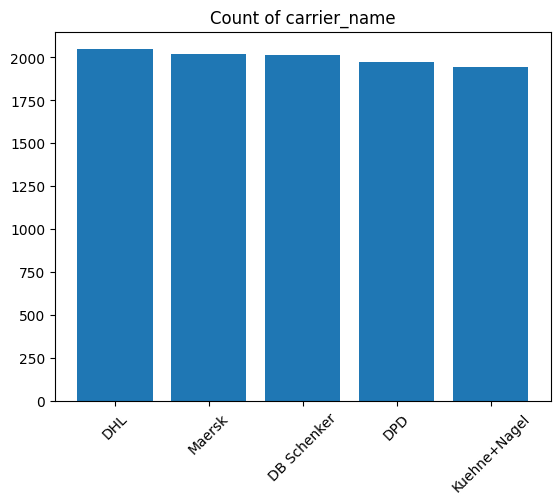

truck_type
Fridge       3367
Box          3324
Tautliner    3309
Name: count, dtype: int64



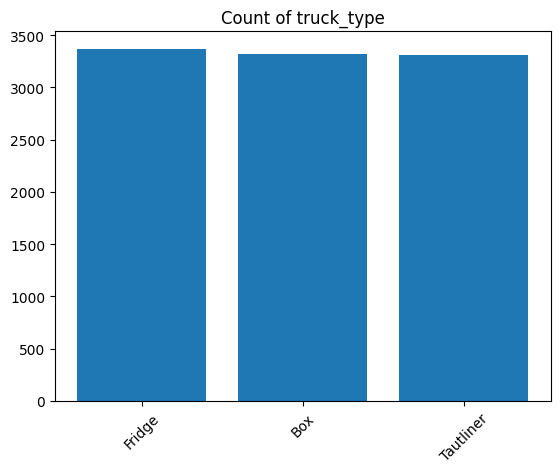

priority_level
Standard    6969
Express     3031
Name: count, dtype: int64



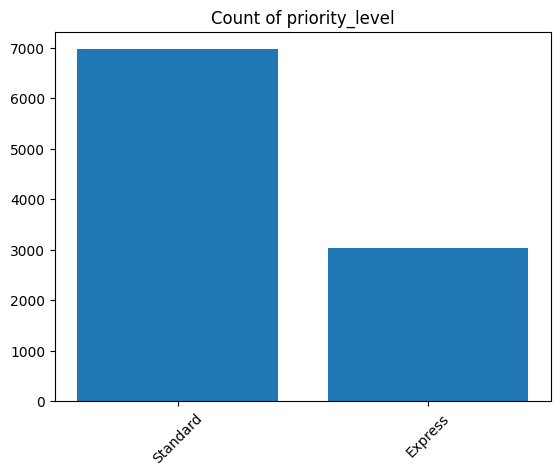

origin_country
Czechia        1076
Portugal       1020
Netherlands    1015
France         1004
Italy           991
Germany         985
Spain           983
Poland          981
Belgium         980
Austria         965
Name: count, dtype: int64



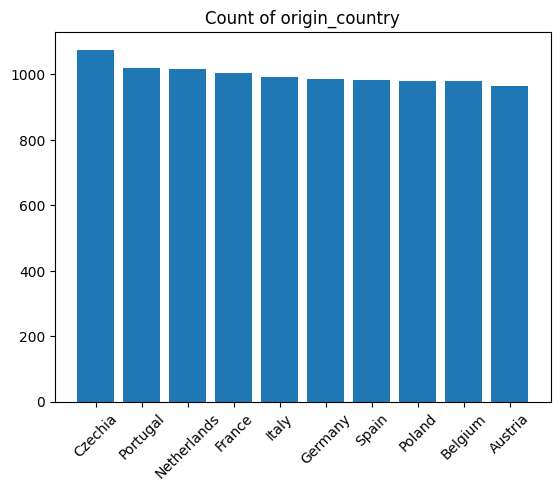

destination_country
Germany        1078
Austria        1046
Portugal       1010
France         1008
Poland          998
Italy           987
Netherlands     975
Belgium         975
Czechia         969
Spain           954
Name: count, dtype: int64



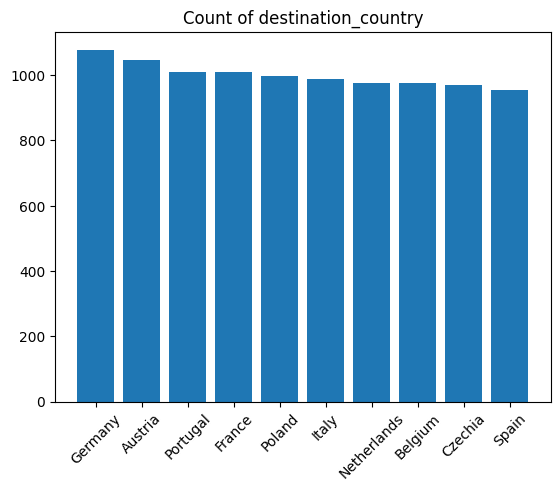

In [178]:
for column in list(df.columns):
    if df[column].dtype == "object":
        value_counts = df[column].value_counts()
        print(value_counts)
        print("")
        plt.bar(x=value_counts.index, height=value_counts)
        plt.title(f"Count of {column}")
        plt.xticks(rotation = 45)
        plt.show()

In [179]:
df['shipment_id'].nunique()

10000

From the Visualisations we can Surmise that:

1. Top 3 Carriers are: DHL (2047 transports), Maersk (2019 transports), DB Schenker (2016 transports)
2. The most used form of truck is the Fridge (3367 transports) followed by Box (3324 transports) and Tautliner (3309 transports)
3. Most of the transports are standard transports making up about 70% of the total transports while 30% of the transports were Express
4. Top 3 countries of origin are Czechia (1076 transports), Portugal (1020 transports) and Netherlands (1015 transports)
5. Top 3 destinations are Germany (1078 transports), Austria (1046 transports), Portugal (1010 transports)

Creating a Route Column to see our top routes

In [180]:
df["route"] = df['origin_country'] + "->" + df['destination_country']

In [181]:
route_value_counts = df['route'].value_counts()
top5_route_value_counts = route_value_counts[:6]

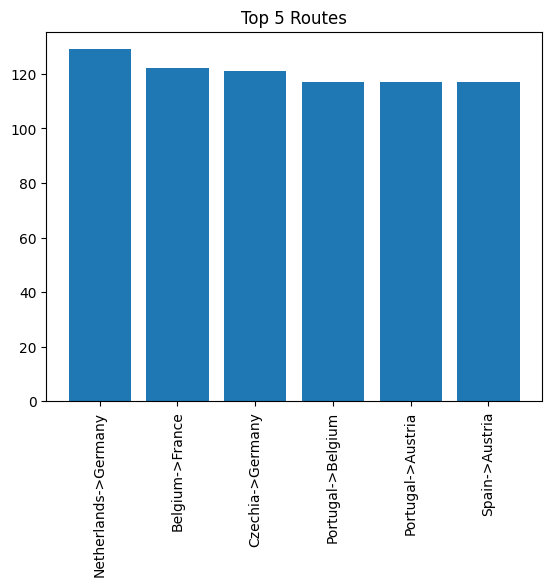

In [182]:
plt.bar(x=top5_route_value_counts.index, height= top5_route_value_counts)
plt.xticks(rotation=90)
plt.title("Top 5 Routes")
plt.show()

In [183]:
least5_route_value_counts = route_value_counts[-5:]
least5_route_value_counts

route
Spain->Portugal         84
Belgium->Netherlands    84
Netherlands->Spain      76
Germany->Netherlands    76
Austria->Czechia        73
Name: count, dtype: int64

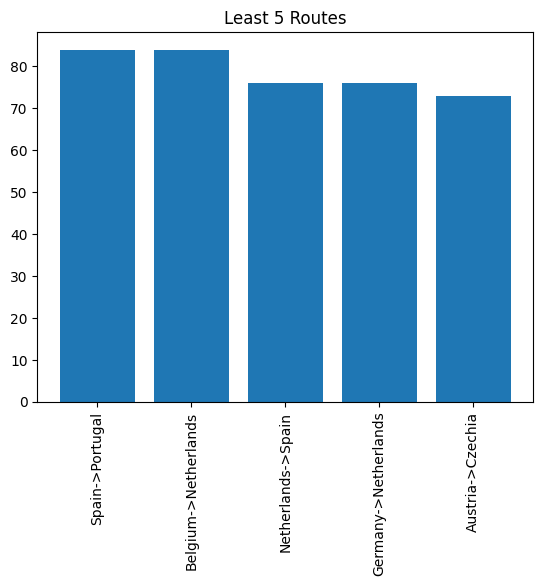

In [184]:
plt.bar(x=least5_route_value_counts.index, height= least5_route_value_counts)
plt.xticks(rotation=90)
plt.title("Least 5 Routes")
plt.show()

Selecting numerical columns and assessing their statistical properties

In [185]:
numerical_columns = df.select_dtypes(['float', "int"])
numerical_columns

,shipment_id,distance_km,weight_tons,volume_m3,delivery_time_days,fuel_price_eur_l,cost_eur
0,1,520,21.7,92.0,5,1.68,2983.05
1,2,106,7.2,68.5,5,1.64,1401.64
2,3,1648,14.7,92.3,4,1.75,3412.53
3,4,2433,21.3,47.4,4,1.66,5692.15
4,5,770,23.1,94.0,6,1.67,2756.15
...,...,...,...,...,...,...,...
9995,9996,2497,21.9,45.6,6,1.82,4368.85
9996,9997,2321,17.7,65.4,4,1.76,5447.45
9997,9998,2263,5.1,81.6,2,1.78,6185.90
9998,9999,1818,1.6,75.1,3,1.88,3850.63


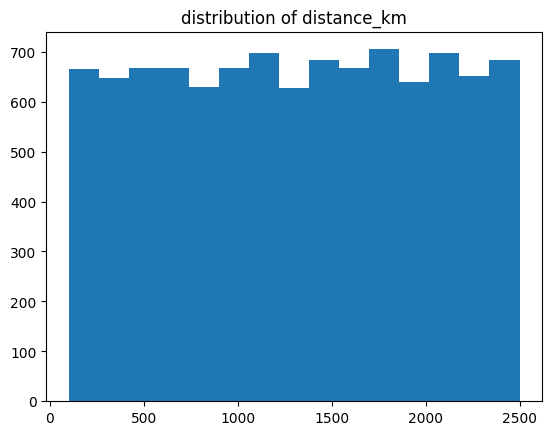

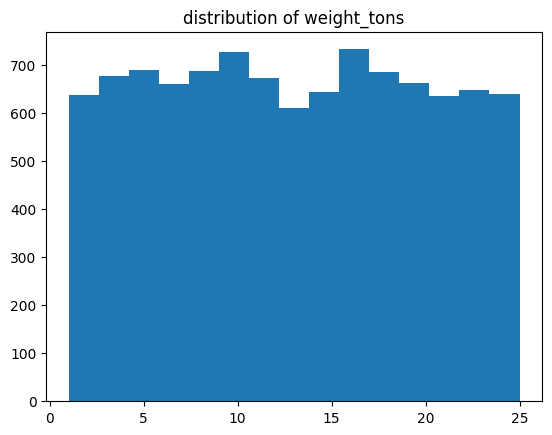

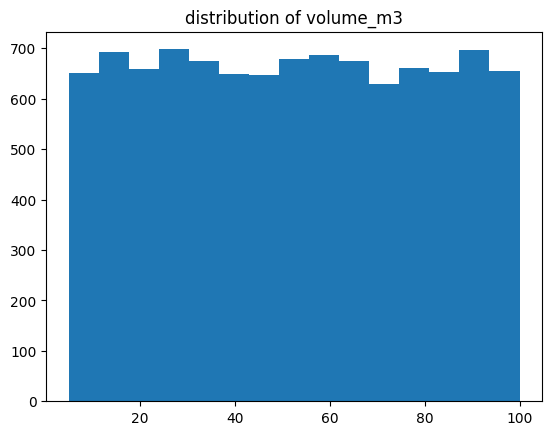

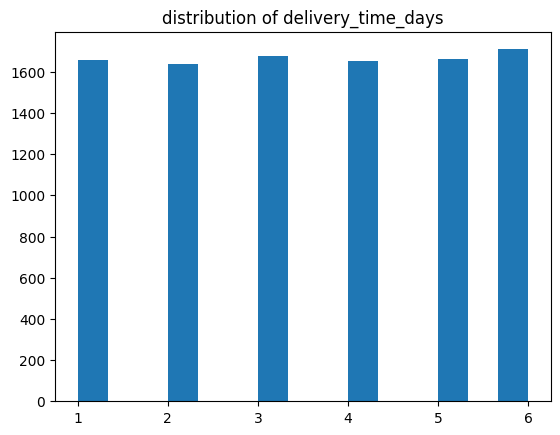

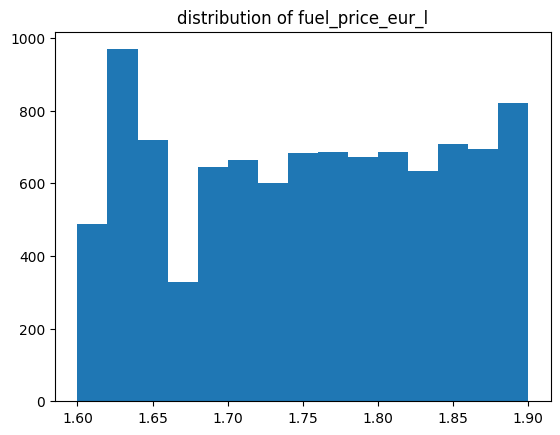

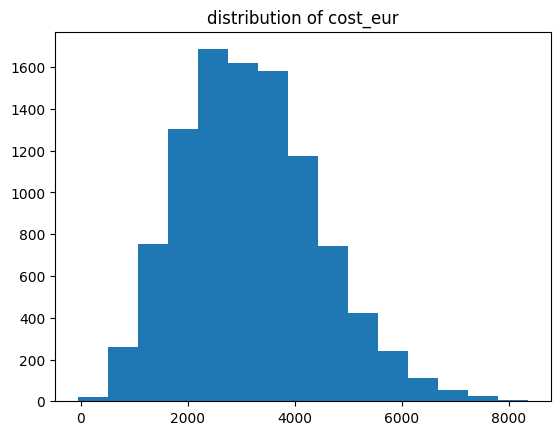

In [186]:
for col in numerical_columns.columns:
    if col != "shipment_id":
        plt.hist(data=df, x=col, bins=15)
        plt.title(f"distribution of {col}")
        plt.show()

In [187]:
# checking outlier costs
df[df["cost_eur"] >= 7000]

,shipment_id,carrier_name,truck_type,distance_km,weight_tons,volume_m3,delivery_time_days,priority_level,origin_country,destination_country,fuel_price_eur_l,cost_eur,route
360,361,DPD,Fridge,2344,22.5,45.7,1,Express,France,Spain,1.78,7352.04,France->Spain
626,627,DPD,Fridge,2471,14.1,88.0,2,Express,France,Portugal,1.63,7021.10,France->Portugal
755,756,Kuehne+Nagel,Fridge,2375,10.3,91.8,2,Express,Czechia,France,1.76,7137.44,Czechia->France
1002,1003,DPD,Fridge,2338,15.9,80.9,4,Express,Poland,Germany,1.84,7618.98,Poland->Germany
1408,1409,Kuehne+Nagel,Fridge,2129,20.4,81.4,2,Express,Italy,Czechia,1.88,7304.17,Italy->Czechia
1411,1412,Kuehne+Nagel,Fridge,2447,25.0,44.3,2,Express,Portugal,Belgium,1.75,7772.74,Portugal->Belgium
1413,1414,Maersk,Fridge,2380,19.0,83.7,4,Express,Germany,Austria,1.83,7644.44,Germany->Austria
1951,1952,DB Schenker,Fridge,2326,24.3,21.8,3,Express,Netherlands,France,1.88,7257.72,Netherlands->France
2087,2088,DPD,Fridge,2297,21.9,50.7,3,Express,Czechia,Poland,1.71,7108.38,Czechia->Poland
2132,2133,DB Schenker,Fridge,2477,22.5,66.3,5,Express,France,Portugal,1.78,7721.44,France->Portugal


In [188]:
# checking characteristics of the highest cost
df[df['cost_eur'] == df['cost_eur'].max()]

,shipment_id,carrier_name,truck_type,distance_km,weight_tons,volume_m3,delivery_time_days,priority_level,origin_country,destination_country,fuel_price_eur_l,cost_eur,route
4551,4552,Kuehne+Nagel,Fridge,2239,22.9,98.6,2,Express,France,Italy,1.85,8372.08,France->Italy


Plotting regression plots between numerical columns and the target variable - cost_eur

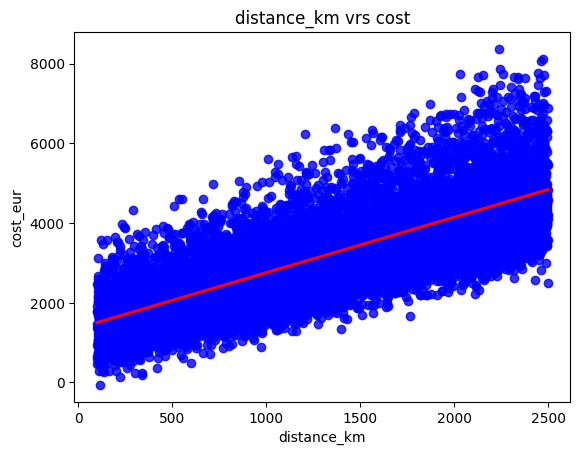

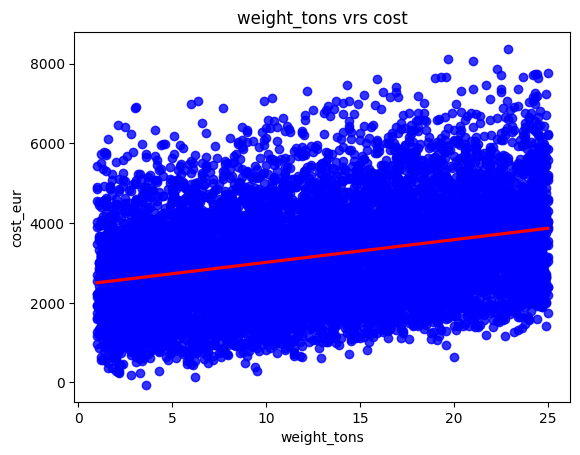

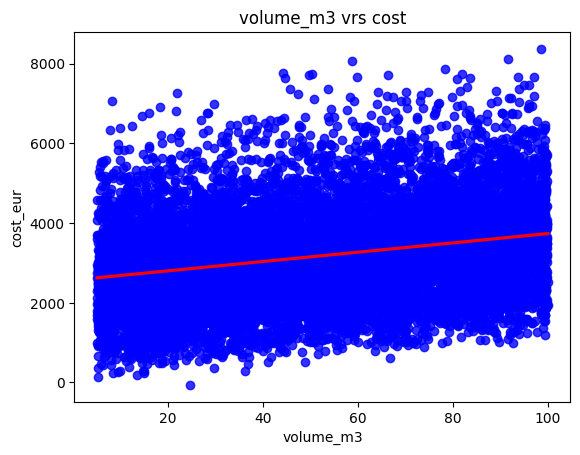

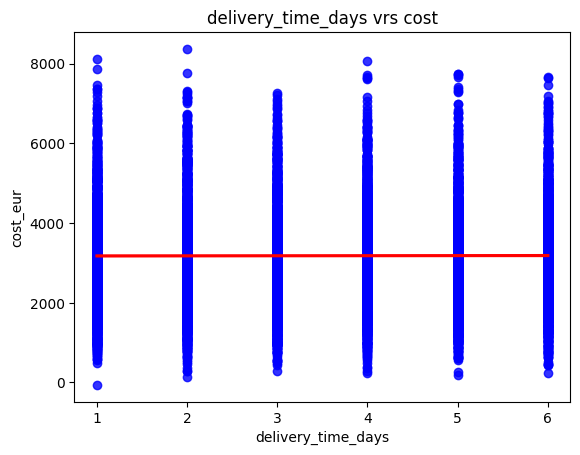

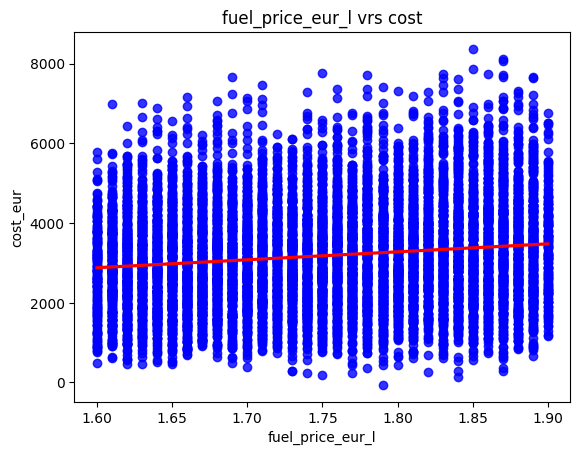

In [189]:
not_needed = ['shipment_id', 'cost_eur']
for col in numerical_columns.columns:
    if col not in not_needed:
        sns.regplot(data=df, x=col, y='cost_eur', color="blue", line_kws={'color': 'red'})
        plt.title(f'{col} vrs cost')
        plt.show()

Assessing Correlation between the numerical columns and the target variable - cost_eur

In [190]:

# assessing the correlation between cost and other numerical columns
not_needed = ['shipment_id', 'cost_eur']
for col in numerical_columns.columns:
    if col not in not_needed:
        print(f'{col}: {df[col].corr(df["cost_eur"])}')

distance_km: 0.7591505223875111
weight_tons: 0.3090999232535876
volume_m3: 0.252940180243454
delivery_time_days: 0.0024419073021665003
fuel_price_eur_l: 0.13633012713341514


It looks like distance_km and weight_tons have the highest correlation to price. Surprisingly fuel cost has a very low correlation with cost. Let try some feature engineering

distance_x_weight

In [191]:
#creating a new column distance_x_weight
df["distnce_x_weight"] = df['distance_km'] * df['weight_tons']

In [192]:
# assessing the correlation between distance_x_weight and cost_eur
print(f"distnce_x_weight : {df["distnce_x_weight"].corr(df['cost_eur'])}")

distnce_x_weight : 0.7100207163343089


the distance_x_weight column provides a balance between the distance and weight correlation figures. However, given how high the correlation between distance and cost is, I will not be using the distance_x_weight

Creating Box plots of object type columns to assess their median cost disparities

In [193]:
for column in df.columns:
        if df[column].dtype == "object":
            # Get categories sorted by median cost, highest to lowest
            order = df.groupby(column)["cost_eur"].median().sort_values(ascending=False).index.tolist()
            
            fig = px.box(
                df, 
                y="cost_eur", 
                color=column, 
                title=f"{column}", 
                category_orders={column: order}
            )
            fig.show()

There are some disparities in median costs with respect to carrier, truck type and priority level. Obviously there are some disparities in routes (origin and destination countries) but we already had that covered with the distance which would be more accurate because not all delivery points in a destination country are the same. The same is true for countries of origin.

Therefore, for this test, I will use the following features:

1. distance_km
2. weight_tons
3. carrier_name
4. truck_type
5. priority_level

Creating a new dataframe with only the needed column



In [194]:
new_df = df[['distance_km', 'weight_tons', 'carrier_name', 'truck_type', 'priority_level', 'cost_eur']]

scaling distance_km and weight_tons

In [195]:
scaler = StandardScaler(with_std=True)
new_df[['distance_km', 'weight_tons']] = scaler.fit_transform(new_df[['distance_km', 'weight_tons']])
new_df.head()

/var/folders/jh/cmy96w8x08vdjgfkk7pkrvk00000gn/T/ipykernel_52783/3109826584.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance_km,weight_tons,carrier_name,truck_type,priority_level,cost_eur
0,-1.134791,1.275703,DPD,Fridge,Standard,2983.05
1,-1.732409,-0.830532,Maersk,Fridge,Standard,1401.64
2,0.493500,0.258900,Kuehne+Nagel,Box,Standard,3412.53
3,1.626663,1.217600,Maersk,Tautliner,Express,5692.15
4,-0.773911,1.479064,Maersk,Box,Standard,2756.15


In [196]:
with open('scaled_data.pkl', 'wb') as f:
    pickle.dump(scaler, f)

One-hot encoding carrier_name, truck_type, priority_level

In [197]:
encoded_columns = pd.get_dummies(new_df[['carrier_name', 'truck_type', 'priority_level']])

In [198]:
encoded_columns

,carrier_name_DB Schenker,carrier_name_DHL,carrier_name_DPD,carrier_name_Kuehne+Nagel,carrier_name_Maersk,truck_type_Box,truck_type_Fridge,truck_type_Tautliner,priority_level_Express,priority_level_Standard
0,False,False,True,False,False,False,True,False,False,True
1,False,False,False,False,True,False,True,False,False,True
2,False,False,False,True,False,True,False,False,False,True
3,False,False,False,False,True,False,False,True,True,False
4,False,False,False,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
9995,True,False,False,False,False,True,False,False,False,True
9996,False,False,False,True,False,False,True,False,False,True
9997,True,False,False,False,False,False,True,False,True,False
9998,False,False,True,False,False,False,True,False,False,True


In [199]:
with open('encoded_data.pkl', 'wb') as f:
    pickle.dump(encoded_columns, f)

In [200]:
#dropping the encoded columns
new_df.drop(['carrier_name', 'truck_type', 'priority_level'], axis=1, inplace=True)

/var/folders/jh/cmy96w8x08vdjgfkk7pkrvk00000gn/T/ipykernel_52783/984312491.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [201]:
new_df.head()

,distance_km,weight_tons,cost_eur
0,-1.134791,1.275703,2983.05
1,-1.732409,-0.830532,1401.64
2,0.493500,0.258900,3412.53
3,1.626663,1.217600,5692.15
4,-0.773911,1.479064,2756.15


In [202]:
#concatenating the old dataframe with the dropped columns and the new encoded columns
new_df = pd.concat([new_df, encoded_columns], axis=1)

In [203]:
new_df.head()

,distance_km,weight_tons,cost_eur,carrier_name_DB Schenker,carrier_name_DHL,carrier_name_DPD,carrier_name_Kuehne+Nagel,carrier_name_Maersk,truck_type_Box,truck_type_Fridge,truck_type_Tautliner,priority_level_Express,priority_level_Standard
0,-1.134791,1.275703,2983.05,False,False,True,False,False,False,True,False,False,True
1,-1.732409,-0.830532,1401.64,False,False,False,False,True,False,True,False,False,True
2,0.493500,0.258900,3412.53,False,False,False,True,False,True,False,False,False,True
3,1.626663,1.217600,5692.15,False,False,False,False,True,False,False,True,True,False
4,-0.773911,1.479064,2756.15,False,False,False,False,True,True,False,False,False,True


Splitting dataframe into x and y variables

In [204]:
X_data = new_df.drop(['cost_eur'], axis=1)
y_data = new_df['cost_eur']

Splitting the X and Y data into training and testing sets

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.3, random_state=1)

Building a Linear Regression Model

In [206]:
lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
model = GridSearchCV(lr, cv=4, param_grid= param_grid)

In [207]:
model.fit(X_train, y_train)

,estimator,LinearRegression()
,param_grid,"{'fit_intercept': [True, False], 'positive': [True, False]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [208]:
print(model.best_estimator_)

LinearRegression(positive=True)


In [209]:
model.best_params_

{'fit_intercept': True, 'positive': True}

In [210]:
best_model = model.best_estimator_

In [211]:
lr_yhat = best_model.predict(X_test)

In [212]:
lr_r2_score = r2_score(lr_yhat, y_test)

In [213]:
lr_mse = mean_squared_error(lr_yhat, y_test)

In [214]:
lr_rmse = root_mean_squared_error(lr_yhat, y_test)

Building a KDE Plot of the Actual v Predicted test values

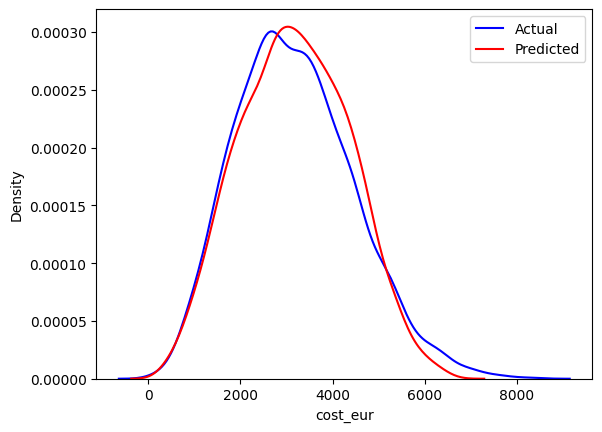

In [215]:
ax1 = sns.kdeplot(y_test, color='blue', )

sns.kdeplot(lr_yhat, color='red', ax=ax1)
plt.legend(['Actual', 'Predicted'])
plt.show()

Building a Ridge Regression Model

In [216]:
ridge_r = Ridge()

param_grid = {'alpha': [10, 1, 0.1, 0.01, 0.001,0.0001]}

ridge_model = GridSearchCV(ridge_r, cv=4, param_grid= param_grid)

In [217]:
ridge_model.fit(X_train, y_train)

,estimator,Ridge()
,param_grid,"{'alpha': [10, 1, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [218]:
print(ridge_model.best_estimator_)

Ridge(alpha=1)


In [219]:
ridge_best_model = ridge_model.best_estimator_

In [220]:
ridge_yhat = ridge_model.predict(X_test)

In [221]:
ridge_r2 = r2_score(ridge_yhat, y_test)

In [222]:
ridge_mse = mean_squared_error(ridge_yhat, y_test)

In [223]:
ridge_rmse = root_mean_squared_error(ridge_yhat, y_test)

Building a KDE Plot of the Actual v Predicted test values

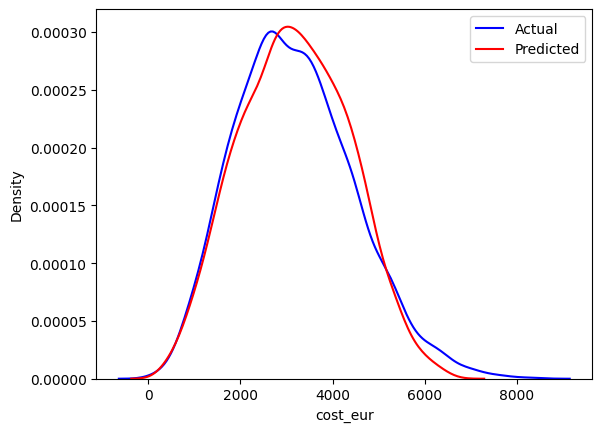

In [224]:
ax1 = sns.kdeplot(y_test, color='blue', )

sns.kdeplot(ridge_yhat, color='red', ax=ax1)
plt.legend(['Actual', 'Predicted'])
plt.show()

In [225]:
print(f'LinearRegression r2_score: {lr_r2_score}')
print(f'ridge_regression r2_score: {ridge_r2}')
print("")
print(f'LinearRegression mse: {lr_mse}')
print(f'ridge_regression mse: {ridge_mse}')
print("")
print(f'LinearRegression rmse: {lr_rmse}')
print(f'ridge_regression rmse: {ridge_rmse}')

LinearRegression r2_score: 0.8481330748454148
ridge_regression r2_score: 0.8480708515281666

LinearRegression mse: 212857.55595774594
ridge_regression mse: 212861.271774982

LinearRegression rmse: 461.3648837501029
ridge_regression rmse: 461.36891071568965


Based on the results, the simple linear regression model is not overfitting because there is no difference between the R2 score of the linear regression model and the ridge regression model

In [226]:
print(f'intercept of the model: {best_model.intercept_}')

intercept of the model: 2503.786300440875


In [227]:
print(f'coefficients of the model: {best_model.coef_}')

coefficients of the model: [961.92607045 400.86628479   0.          14.93864288   5.24245972
  19.5549305    8.47491394   0.         914.36490919 290.9579009
 866.49758998   0.        ]


Building a function that uses the model to predict spot freight cost

In [ ]:
with pickle.sa

In [170]:
def spot_freight_cost_predictor(distance_km, weight_tons, carrier_name, truck_type, priority_level):
    """ This function uses a linear regression model to predict spot freight costs. 
    It creates a dataframe out of the input variables, scales and encodes various columns and applies the model to make a prediction"""

    df = pd.DataFrame({'distance_km': [distance_km],
                       'weight_tons': [weight_tons],
                       'carrier_name': [carrier_name],
                       'truck_type': [truck_type],
                       'priority_level': [priority_level]})
    
    df_encoders = pd.get_dummies(df[['carrier_name', 'truck_type', 'priority_level']])
    df = df.drop(['carrier_name', 'truck_type', 'priority_level'], axis=1)
    df = pd.concat([df, df_encoders], axis=1)
    with open("encoded_data.pkl", "rb") as f:
        encoders = pickle.load(f)
        for col in encoders.columns:
                if col not in df.columns:
                      df[col] = 0
    with open('scaled_data.pkl', 'rb') as g:
        scaled = pickle.load(g)
        df[['distance_km', 'weight_tons']] = scaled.transform(df[['distance_km', 'weight_tons']])
    
    df = df[['distance_km', 'weight_tons', 'carrier_name_DB Schenker', 'carrier_name_DHL', 'carrier_name_DPD', 'carrier_name_Kuehne+Nagel', 'carrier_name_Maersk', 'truck_type_Box', 'truck_type_Fridge',
       'truck_type_Tautliner', 'priority_level_Express','priority_level_Standard']]
    
    suggested_cost = model.predict(df)
    suggested_cost = round(suggested_cost[0],2)

    return f"given the distance {distance_km} KM, {weight_tons} tons, using {carrier_name} and {truck_type}, and {priority_level} priority, the suggested price is {suggested_cost} Eur"
    

Test 1. 
Carrier: DPD	
Truck Type: Fridge	
Distance_km: 520	
Weight_tons: 21.7
Priority Level: Standard
Contracted Cost:	2983.05 EUR

In [171]:
spot_freight_cost_predictor(520, 21.7, 'DPD', 'Fridge','Standard')

'given the distance 520 KM, 21.7 tons, using DPD and Fridge, and Standard priority, the suggested price is 2843.2 Eur'

Conclusion:

This notebook as answered fundamental questions about the company's logistical costs and built a linear regression model that predicts the cost transporting goods. The model explains 84% of the variance in the target variable. This model will serve as a guide for Spot Freights and makes accomodation for flexibilty and intuitive human decision making